## Import

In [2]:
from aiida import load_profile, orm

# specify the name that you used while setting up the profile using verdi quicksetup
load_profile("me")
from aiida.common.exceptions import NotExistent
from aiida.plugins import WorkflowFactory, CalculationFactory, GroupFactory
from aiida_quantumespresso.common.types import ElectronicType
from aiida.engine import submit
import numpy as np
import matplotlib.pyplot as plt
import time
from pymatgen.core.periodic_table import Element
from ase.io import read, write
import time

bohr_to_ang = 0.52917720859
ry_to_ev = 13.6056917253

## PreProcessing

### extxyz dataset generation

In [3]:
## Loading variables

trajectory = orm.load_node("3be5344a-8677-4be9-9f91-52549cb0436a")  # 2fs
stride = 3  # we only take every 3rd data point as all these configurations are highly correlated
equilibration = (
    300  # we skip the first few datapoints till the system reaches equilibirum
)

positions = trajectory.get_array("positions")[equilibration::stride]
forces = trajectory.get_array("forces")[equilibration::stride]
energies = trajectory.get_array("energy")[equilibration::stride]
stresses = trajectory.get_array("stress")[equilibration::stride]
cells = trajectory.get_array("cells")[equilibration::stride]

symbols = trajectory.attributes["symbols"]
nat = len(symbols)

print(
    positions.shape,
    forces.shape,
    energies.shape,
    stresses.shape,
    cells.shape,
    len(symbols),
)

(1633, 56, 3) (1633, 56, 3) (1633,) (1633, 3, 3) (1633, 3, 3) 56


In [15]:
## To print out training set

with open("iteration_1.extxyz", "w") as file:
    # redirect stdout to the file
    sys.stdout = file

    # the print statements here
    for position, force, cell, energy, stress in zip(
        positions, forces, cells, energies, stresses
    ):
        cell_to_print = " ".join(map(str, cell.flatten()))
        stress_to_print = " ".join(map(str, stress.flatten()))
        print(nat)
        print(
            f'Lattice="{cell_to_print}" Properties=species:S:1:pos:R:3:forces:R:3 energy={energy} stress="{stress_to_print}" pbc="T T T"'
        )
        for symbol, pos, fo in zip(symbols, position, force):
            print(
                symbol,
                " ".join(map(str, pos.flatten())),
                " ".join(map(str, fo.flatten())),
            )

    # reset stdout to the console
    sys.stdout = sys.__stdout__

In [ ]:
# To ensure that the generated dataset is readable by ase
frames = read(filename="Li3BS3.extxyz", format="extxyz", index=":")
write(images=frames, filename="lbs.extxyz", append=True, format="extxyz")

In [ ]:
## list of important hyperparameters to optimise
num_layers = 4
num_features = 32
l_max = 2
r_max = 4.0
learning_rate = 0.0075
parity = False
optimizer_amsgrad = False

### npz dataset generation

In [ ]:
## We did not use this but we keep it here for future reference

In [73]:
## To check what are the fields in the npz file
train = np.load(
    "/home/tthakur/git/cs433/project2/ex_runs/benchmark_data/aspirin_ccsd-train.npz"
)
print(train.files)
train["E"].shape, train["name"], train["F"].shape, train["R"].shape, train["z"].shape

['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']


((1000, 1),
 array(b'aspirin_ccsd', dtype='|S12'),
 (1000, 21, 3),
 (1000, 21, 3),
 (21,))

In [ ]:
trajectory = orm.load_node("0f7277a0-b7c2-4935-9108-7414f87d760e")

# In trajectory
# Energies in eV
# Positions in Ang
# Forces in eV/Ang
# z is species atomic no.

In [55]:
positions = trajectory.get_array("positions")
forces = trajectory.get_array("forces")
energies = trajectory.get_array("energy").reshape(-1, 1)
stresses = trajectory.get_array("stress")

symbols = trajectory.attributes["symbols"]
z = [Element(sym).number for sym in symbols]
tiled_symbols = np.tile(z, (len(energies), 1))

cell = trajectory.get_array("cells")[0]
N = len(energies)

np.savez(
    "data_set.npz",
    z=tiled_symbols,
    E=energies,
    F=forces,
    R=positions,
    pbc=True,
    cell=cell,
)

In [ ]:
symbols = trajectory.attributes["symbols"]
nat = len(symbols)
cell = trajectory.get_array("cells")[0]

# Load the files
# Energies in Ry
# Positions in Ang
# Forces in Ry/bohr
energies = np.loadtxt("energies")
positions = np.loadtxt("allpositions_all")
forces = np.loadtxt("forces")

b2a = 0.529177

#
N = len(energies)

#############
# TRAIN SET #
#############
#
E = np.zeros([N, 1], float)
R = np.zeros([N, nat, 3], float)
F = np.zeros([N, nat, 3], float)
z = np.zeros([N, nat], float)
#
with open("calculated_energies", "w") as f, open("calculated_forces", "w") as f2:
    for i in range(N):
        E[i] = energies[i] * 13.6  # (eV)
        f.write("%12.8f \n" % E[i])
        #
        idx = nat * i
        for j in range(nat):
            R[i, j, :] = positions[idx + j, 1:]  # ang
            F[i, j, :] = forces[idx + j, :] * 13.6 / b2a  # eV/ang
            f2.write(
                "%12.8f %12.8f %12.8f \n"
                % (abs(F[i, j, 0]), abs(F[i, j, 1]), abs(F[i, j, 2]))
            )
            z[i, j] = int(anum[int(positions[idx + j, 0]) - 1])

pbc = (True, True, True)

np.savez("data_set.npz", z=z, E=E, F=F, R=R, pbc=pbc, cell=cell)

### Lammps input generation

In [5]:
lbs_ss = orm.load_node("2797878d-d875-423e-b95b-f781966f3e27")  # 56 atoms
write(images=lbs_ss.get_ase(), filename="LBS.lmp", format="lammps-data")

## NOTE: the file generated here has Li as species 2 and B as species 1 so need to reverse that manually

## FPMD

### Structure generation

In [ ]:
# Run following in the conda environment `aiida168` to generate the supercells
# please note that this cell will not run in this environment as the required modules are not installed

from aiida_flipper.workflows.preprocess import (
    make_supercell_distance,
    delithiate_structure,
)

# The following structure was generated using a cif file containing experimental structure and cleaned using aiida_codtools
structure = orm.load_node("079a963c-358d-4c7b-a37e-1532f2c1540c")
ss8 = make_supercell_distance(structure, orm.Float(8.0))  # 56 atoms
ss10 = make_supercell_distance(structure, orm.Float(10.0))  # 84 atoms

# Showing a workable example of how this was done is beyond the scope as it requires a lot of different aiida plugins,
# which have their own complex dependencies

In [3]:
lbs_uc = orm.load_node("079a963c-358d-4c7b-a37e-1532f2c1540c")
# lbs_ss = orm.load_node('075d6d25-40af-4176-9d8f-e2a17302b2e8') # 84 atoms
# we use smaller supercell for faster calculation
lbs_ss = orm.load_node("2797878d-d875-423e-b95b-f781966f3e27")  # 56 atoms

### Launching calculation

In [5]:
## MD calculations

## IMPORTANT: This cell will not work if you don't have the permission to use the LUMI-GPU cluster

"""
Run 1 = 40975
dt = 80, fixed occupations, nosym = False, kpoints = [3,3,2]

Run 2 = 40990
dt = 40, gaussian smearing = 0.003, nosym = True, kpoints = [2,2,2]

Run 3 = 42170 on daint
dt = 80, fixed occupations, nosym = True, kpoints = [2,2,2]

Run 4 = 63976
dt = 40, fixed occupations, nosym = True, kpoints = [3,3,2]
This is the one that we use finally

"""

PwBaseWorkChain = WorkflowFactory("quantumespresso.pw.base")
overrides = {"pseudo_family": "SSSP/1.3/PBEsol/efficiency"}

group_label = "Project_2_aimd_pbesol_daint_gpu"
try:
    group = orm.load_group(group_label)
except NotExistent:
    print(f"Group<{group_label}> does not exist, creating...")
    group = orm.Group(label=group_label)
    group.store()

builder = PwBaseWorkChain.get_builder_from_protocol(
    code=orm.load_code("qe-sirius@lumi-gpu"),
    structure=lbs_ss,
    overrides=overrides,
    electronic_type=ElectronicType.INSULATOR,
)

builder.pw.metadata.options["mpirun_extra_params"] = [
    "--cpu-bind=verbose,${CPU_BIND}",
    "--gpu-bind=verbose,${GPU_BIND}",
]

builder.pw.metadata["options"]["max_wallclock_seconds"] = 172500
builder.pw.metadata["options"]["resources"]["num_machines"] = 1

builder.pw.parallelization = orm.Dict(dict={"npool": 8})

builder["pw"]["parameters"]["CONTROL"]["calculation"] = "md"
builder["pw"]["parameters"]["CONTROL"]["dt"] = 40
builder["pw"]["parameters"]["CONTROL"]["iprint"] = 1
builder["pw"]["parameters"]["CONTROL"]["nstep"] = 5200  # 10ps
builder["pw"]["parameters"]["CONTROL"]["verbosity"] = "low"

builder["pw"]["parameters"]["SYSTEM"]["nosym"] = True

builder["pw"]["parameters"]["ELECTRONS"]["conv_thr"] *= 10
builder["pw"]["parameters"]["ELECTRONS"]["mixing_beta"] = 0.2

builder["max_iterations"] = orm.Int(3)

para_d = builder["pw"]["parameters"].get_dict()

para_d.update(
    {
        "IONS": {
            "ion_temperature": "svr",
            "ion_velocities": "from_input",
            "nraise": 100,
            "tempw": 1000,
            "wfc_extrapolation": "first_order",
            "pot_extrapolation": "first_order",
        }
    }
)

builder["pw"]["parameters"] = orm.Dict(dict=para_d)
builder["pw"]["settings"] = orm.Dict(
    {"gamma_only": False, "cmdline": ["-sirius_cfg", "sirius.json"]}
)

builder["kpoints_distance"] = orm.Float(0.33)

builder.clean_workdir = orm.Bool(False)

wc_node = submit(builder)

print(f"Submitted BaseWorkChain with PK = {wc_node.pk} to Group <{group.label}>")
group.add_nodes(wc_node)

Submitted BaseWorkChain with PK = 63976 to Group <Project_2_aimd_pbesol_daint_gpu>


### Querying

In [4]:
group_lable = "Project_2_aimd_pbesol_daint_gpu"
qb = orm.QueryBuilder()
qb.append(orm.Group, filters={"label": {"like": group_lable}}, tag="imported_g")
qb.append(
    WorkflowFactory("quantumespresso.pw.base"),
    with_group="imported_g",
    tag="base",
    filters={
        "and": [
            {"attributes.process_state": {"==": "finished"}},
        ]
    },
)
print(qb.count())
base_wcs = qb.all(flat=True)
qb.append(orm.TrajectoryData, with_incoming="base")
trajectories = qb.all(flat=True)
for traj in trajectories:
    print(traj.get_array("positions").shape)

# Based on the shape, only the last calculation generated all the data needed for training

4
(1, 56, 3)
(1, 56, 3)
(5199, 56, 3)


## New dataset generation

### Launching calculation

In [ ]:
## Taking the dumps of lammps i.e. configurations generated during the MD simulation,
## and launching PwBaseWC on them i.e. run DFT calculations to get more data for further training
## l_dump also contains forces so this can be useful to plot NequIP forces with DFT forces

In [12]:
## IMPORTANT: This cell will not work if you don't have the permission to use the LUMI-GPU cluster

## Taking the dumps of lammps and launching PwBaseWC on them to get more training data
lammps_dump = (
    "/home/tthakur/git/cs433/project2/cs433-project-2/simulations/MD_1_2/dump_all.lmc"
)
l_dump_all = read(lammps_dump, format="lammps-dump-text", index=":")

PwBaseWorkChain = WorkflowFactory("quantumespresso.pw.base")
overrides = {"pseudo_family": "SSSP/1.3/PBEsol/efficiency"}

group_label = "Project_2_DFT_calculations_lumi_gpu"
try:
    group = orm.load_group(group_label)
except NotExistent:
    print(f"Group<{group_label}> does not exist, creating...")
    group = orm.Group(label=group_label)
    group.store()

# Not using the last few configurations that exploded
for idx, l_dump in enumerate(l_dump_all[:1000]):

    structure = orm.StructureData()
    structure.set_ase(l_dump)
    structure.set_extra("lammps_file", f"dump_{idx+1}")

    builder = PwBaseWorkChain.get_builder_from_protocol(
        code=orm.load_code("qe-sirius@lumi-gpu"),
        structure=structure,
        overrides=overrides,
        electronic_type=ElectronicType.INSULATOR,
    )

    builder.pw.metadata.options["mpirun_extra_params"] = [
        "--cpu-bind=verbose,${CPU_BIND}",
        "--gpu-bind=verbose,${GPU_BIND}",
    ]

    # Short calculations
    builder.pw.metadata["options"]["max_wallclock_seconds"] = 1800
    builder.pw.metadata["options"]["resources"]["num_machines"] = 1

    builder.pw.parallelization = orm.Dict(dict={"npool": 8})

    builder["pw"]["parameters"]["CONTROL"]["verbosity"] = "low"

    builder["pw"]["parameters"]["SYSTEM"]["nosym"] = False

    builder["pw"]["parameters"]["ELECTRONS"]["conv_thr"] *= 10
    builder["pw"]["parameters"]["ELECTRONS"]["mixing_beta"] = 0.2
    builder["pw"]["parameters"]["ELECTRONS"]["electron_maxstep"] = 200

    builder["pw"]["settings"] = orm.Dict(
        {"gamma_only": False, "cmdline": ["-sirius_cfg", "sirius.json"]}
    )

    builder["max_iterations"] = orm.Int(2)

    builder["kpoints_distance"] = orm.Float(0.30)

    builder.clean_workdir = orm.Bool(False)

    wc_node = submit(builder)

    print(f"Submitted BaseWorkChain with PK = {wc_node.pk} to Group <{group.label}>")

    # to not overload the daemon
    time.sleep(5)

    group.add_nodes(wc_node)

Submitted BaseWorkChain with PK = 69912 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 69927 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 69942 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 69957 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 69974 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 69989 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 70004 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 70019 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 70034 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 70049 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 70065 to Group <Project_2_DFT_calculations_lumi_gpu>
Submitted BaseWorkChain with PK = 70084 to 

KeyboardInterrupt: 

### Forces comparison

235


/tmp/ipykernel_2270088/963559115.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


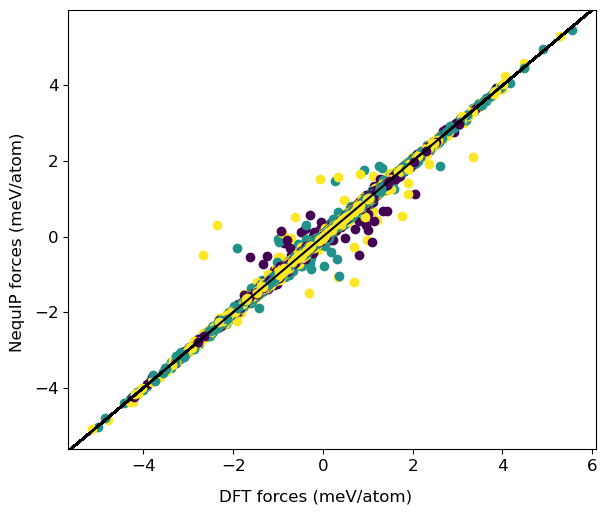

In [5]:
## Forces comparison DFT vs Nequip

# Querying DFT workchains
group_lable = "Project_2_DFT_calculations_lumi_gpu"
qb = orm.QueryBuilder()
qb.append(orm.Group, filters={"label": {"like": group_lable}}, tag="imported_g")
qb.append(
    WorkflowFactory("quantumespresso.pw.base"),
    with_group="imported_g",
    tag="base",
    filters={
        "and": [
            {"attributes.process_state": {"==": "finished"}},
        ]
    },
)
print(qb.count())
base_wcs = qb.all(flat=True)

plt.rcParams.update({"font.size": 12, "axes.labelsize": 12})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
colormap = plt.colormaps["viridis"]

lammps_dump = (
    "/home/tthakur/git/cs433/project2/cs433-project-2/simulations/MD_1_2/dump_all.lmc"
)
l_dump_all = read(lammps_dump, format="lammps-dump-text", index=":")

for wc in base_wcs:
    traj = wc.outputs.output_trajectory
    file = wc.inputs.pw.structure.extras["lammps_file"]
    l_dump = l_dump_all[int(file.split("_")[1]) - 1]

    force_dft = traj.get_array("forces")
    force_nequip = l_dump.get_forces()

    num_columns = force_nequip.shape[1]

    # Loop through each column and assign a different color
    for i in range(num_columns):
        color = colormap(i / (num_columns - 1))  # Normalize the column index to [0, 1]
        ax.plot(force_dft[0, :, i], force_nequip[:, i], "o", color=color)

    ax.axline(xy1=(0, 0), slope=1, color="black")

fig.tight_layout()
fig.text(0.5, -0.02, "DFT forces (meV/atom)", fontsize=12, ha="center")
fig.text(
    -0.01,
    0.5,
    "NequIP forces (meV/atom)",
    fontsize=12,
    va="center",
    rotation="vertical",
)
fig.show()